# 1. Setup

Use GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the Git repo. 

In [1]:
!rm -rf /content/Diffusion
%cd /content




/content


In [2]:
!git clone -b fix/dataloader-phys --single-branch https://github.com/Riccardo582/Diffusion.git
%cd Diffusion/


Cloning into 'Diffusion'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 183 (delta 94), reused 152 (delta 63), pack-reused 0 (from 0)
Receiving objects: 100% (183/183), 4.81 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/Diffusion


In [11]:
!ls
import os, sys
os.chdir("Diffusion")
sys.path.append(os.getcwd())


#pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT ,DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [ ]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!


# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [ ]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [12]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())


In [ ]:
!torchrun --nnodes=1 --nproc_per_node=1 train.py \
  --model DiT-S/2 \
  --data-path data/datasets/data/darcy_train_16.pt \
  --ckpt-every 25 \
  --image-size 16 \
  --cx 1 \
  --cy 1 \
  --epochs 100 \
  --global-batch-size 8 \
  --num-workers 2


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Starting rank=0, seed=0, world_size=1.
[2026-02-03 15:00:52] Experiment directory created at results/000-DiT-S-2
[2026-02-03 15:00:53] DiT Parameters: 32,466,820
[2026-02-03 15:00:53] Dataset contains 1,000 PDE samples (data/datasets/data/darcy_train_16.pt)
[2026-02-03 15:00:53] Training for 500 epochs...
[2026-02-03 15:00:53] Beginning epoch 0...
x_cond shape: torch.Size

In [5]:
!ls results/000-DiT-S-2 | head 

!find results/000-DiT-S-2/checkpoints -maxdepth 1 -type f -printf "%f\n" | head -n 50


!tensorboard --logdir results --bind_all --port 6006



checkpoints
log.txt
0000950.pt
0006250.pt
0000100.pt
0004600.pt
0006700.pt
0005250.pt
0006850.pt
0000550.pt
0001500.pt
0000700.pt
0001300.pt
0001350.pt
0000400.pt
0004250.pt
0004400.pt
0003900.pt
0003700.pt
0001950.pt
0005850.pt
0002700.pt
0001650.pt
0002400.pt
0000300.pt
0005550.pt
0001000.pt
0001250.pt
0000050.pt
0001600.pt
0006650.pt
0003300.pt
0003100.pt
0001750.pt
0005200.pt
0006400.pt
0005500.pt
0002600.pt
0001450.pt
0002750.pt
0004050.pt
0006550.pt
0000450.pt
0002250.pt
0006100.pt
0007250.pt
0002000.pt
0004800.pt
0003400.pt
0005900.pt
0001850.pt
0004850.pt
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:292: SyntaxWarning: invalid escape sequence '\s'
  "[`\000-\040\177-\240\s]+",
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitizer.py:339: SyntaxWarning: invalid escape sequence '\s'
  style = re.compile('url\s*\(\s*[^\s)]+?\s*\)\s*').sub(' ', style)
/usr/local/lib/python3.12/dist-packages/tensorboard/_vendor/bleach/sanitiz

checkpoints  log.txt
Parsed 72 points from results/000-DiT-S-2/log.txt


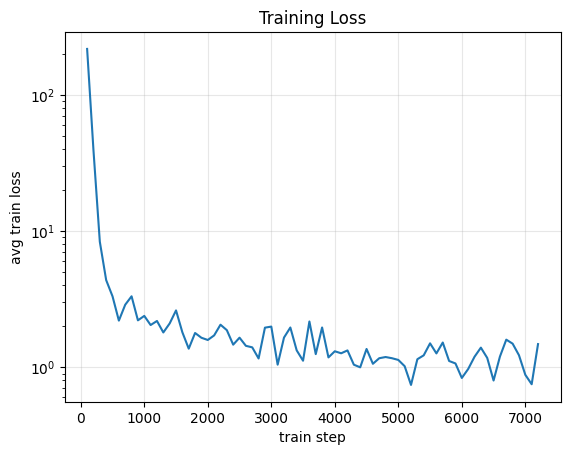

In [4]:

import re
import matplotlib.pyplot as plt

!ls results/000-DiT-S-2

LOG = "results/000-DiT-S-2/log.txt"  

steps, loss = [], []
pat = re.compile(r"\(step=(\d+)\)\s+Train Loss:\s+([0-9.]+)")

with open(LOG, "r") as f:
    for line in f:
        m = pat.search(line)
        if m:
            steps.append(int(m.group(1)))
            loss.append(float(m.group(2)))

print(f"Parsed {len(loss)} points from {LOG}")
if len(loss) == 0:
    raise SystemExit("No loss lines found. Check LOG path or log format")

plt.figure()
plt.semilogy(steps, loss)
plt.xlabel("train step")
plt.ylabel("avg train loss")
plt.title("Training Loss")
plt.grid(alpha=0.3)
plt.show()



Sample from the trained model


In [ ]:
torchrun --nproc_per_node=1 sample_cfd_ddp.py \
  --data data/datasets/data/darcy_test_32.pt \
  --ckpt results/001-DiT-S-2/checkpoints/ema.pt \
  --model DiT-S/2 \
  --image-size 32 \
  --cx 1 --cy 1 \
  --pos-mode learned \
  --num-samples 1024 \
  --per-proc-batch-size 8 \
  --num-sampling-steps 250 \
  --sample-dir cfd_samples
